In [193]:
import pandas as pd
import seaborn as sns
from scipy import stats

## data prep
from sklearn.model_selection import train_test_split
import missingno as msno 

## modeling
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor



## evaluation
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

## visualization 
from plotnine import *
from plotly.offline import iplot
import plotly_express as px


In [65]:
df = pd.read_csv('../washington-post-election-night-model/data/county_data.csv')

In [66]:
## change fips to string
df['fips'] = df['fips'].astype(str)
df['fips'] = df['fips'].str.zfill(5)

In [67]:
## features we will mainly use
features = [
    'fips',
    'female',
    'male',
    'white',
    'black',
    'aapi',
    'hispanic',
    'other_race_alone',
    'median_income',
    'bachelor_or_higher',
    'age_le_30',
    'age_ge_30_le_45',
    'age_ge_45_le_65',
    'age_ge_65',
    'total_votes_2016'
]

# Target variable

In [68]:
df['vote_change']=(df['total_votes_2020']-df['total_votes_2016'])


# Data Prep

##### Explore which counties are blank

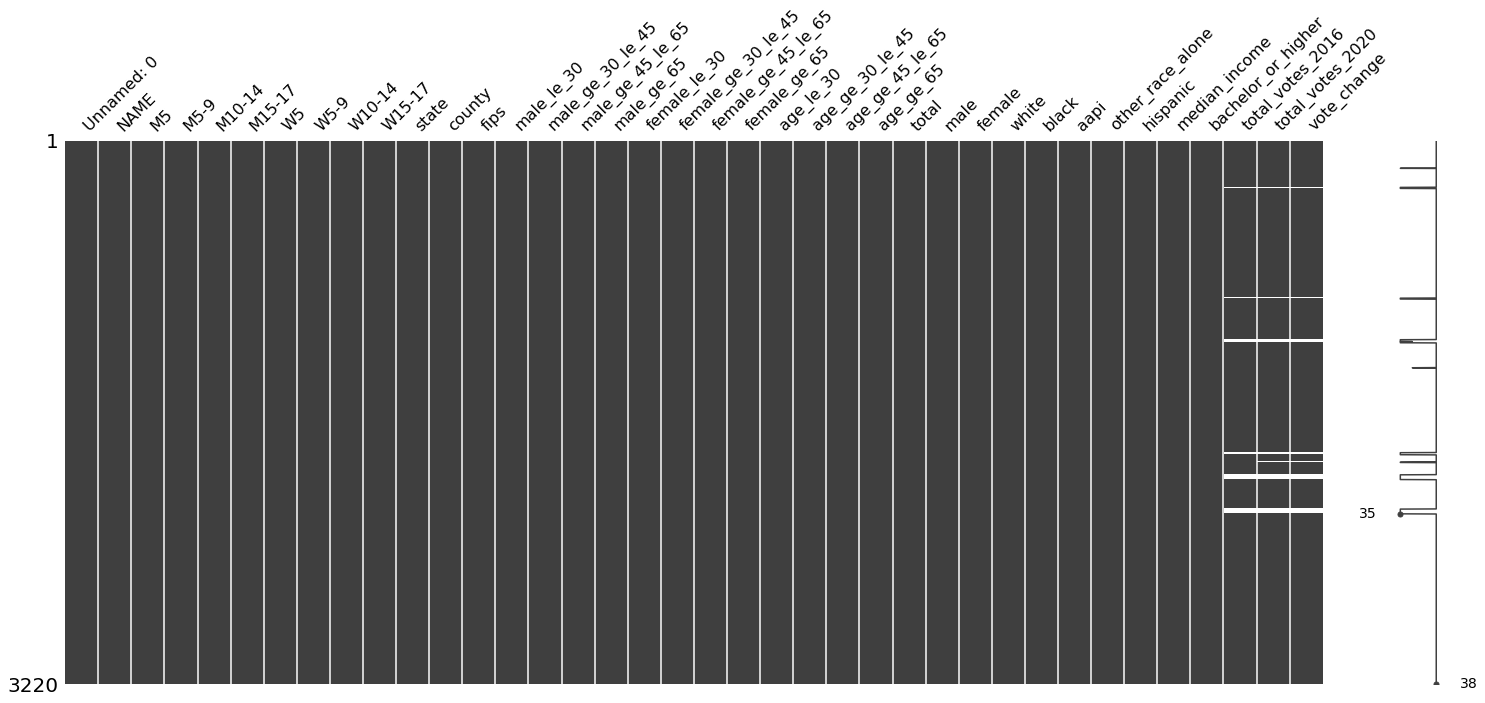

In [69]:
msno.matrix(df) 

In [70]:
df = df.dropna()


##### Train test split

In [73]:
X = df[features]
y = df['total_votes_2020']

In [74]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=1)

# Parametric, OLS

In [124]:
reg = LinearRegression()
reg.fit(Xtrain, ytrain)

LinearRegression()

In [76]:
reg_ypred = reg.predict(Xtest)
reg_ytrue = ytest

r2_score(reg_ytrue, reg_ypred)

0.9802803806652125

##### Evaluate how close the guesses are 

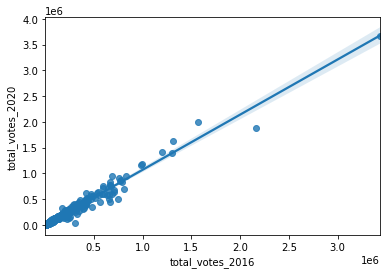

In [77]:
sns.regplot(x='total_votes_2016', y='total_votes_2020', data=df)

##### Evaluate percentage off, so difference of predicted vs actual 

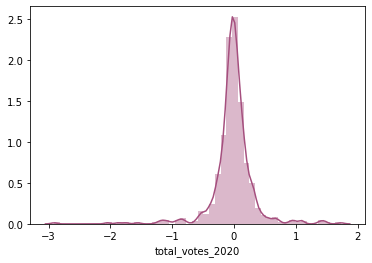

In [83]:
test=(reg_ypred - reg_ytrue)/reg_ytrue
sns.distplot(test, color = "#a54f7e")

##### Generating prediction intervals and then counting counties in interval vs. out of interval.

We can calculate the percentage of the time the actual value is within the range, but this can be easily optimized by making the interval very wide. Therefore, we also want a metric that takes into account how far away the predictions are from the actual value, such as absolute error.


In the notebook, I’ve provided a function that calculates the absolute error for the lower, mid, and upper predictions and then averages the upper and lower error for an “Interval” absolute error. We can do this for each data point and then plot a boxplot of the errors (the percent in bounds is in the title):

https://towardsdatascience.com/how-to-generate-prediction-intervals-with-scikit-learn-and-python-ab3899f992ed

In [86]:
# Set lower and upper quantile
LOWER_ALPHA = 0.15
UPPER_ALPHA = 0.85

N_ESTIMATORS = 100
MAX_DEPTH = 5

# Each model has to be separate

lower_model = GradientBoostingRegressor(
    loss="quantile", alpha=LOWER_ALPHA, n_estimators=N_ESTIMATORS, max_depth=MAX_DEPTH
)
# The mid model will use the default
mid_model = GradientBoostingRegressor(loss="ls", n_estimators=N_ESTIMATORS, max_depth=MAX_DEPTH)

upper_model = GradientBoostingRegressor(
    loss="quantile", alpha=UPPER_ALPHA, n_estimators=N_ESTIMATORS, max_depth=MAX_DEPTH
)

In [89]:
lower_model.fit(Xtrain, ytrain)

GradientBoostingRegressor(alpha=0.15, loss='quantile', max_depth=5)

In [90]:
mid_model.fit(Xtrain, ytrain)

GradientBoostingRegressor(max_depth=5)

In [91]:
upper_model.fit(Xtrain, ytrain)

GradientBoostingRegressor(alpha=0.85, loss='quantile', max_depth=5)

In [101]:
predictions = pd.DataFrame(ytest)
predictions['lower'] = lower_model.predict(Xtest)
predictions['mid'] = mid_model.predict(Xtest)
predictions['upper'] = upper_model.predict(Xtest)

#assert (predictions['upper'] > predictions['lower']).all()

predictions.tail()

,total_votes_2020,lower,mid,upper
2569,16819.0,16264.672715,17139.102207,19882.470591
2399,930.0,765.646781,1076.433023,1201.546141
2468,36795.0,35359.056896,37059.951681,44121.318128
1301,17675.0,15968.115590,16498.844926,16260.537918
2911,1165.0,1289.511488,1322.224505,1175.415812


In [ ]:
iplot(fig)

In [211]:
def calculate_error(df):
    """
    Calculate the absolute error associated with prediction intervals
    
    :param predictions: dataframe of predictions
    :return: None, modifies the prediction dataframe
    
    """
    df['absolute_error_lower'] = (df['lower'] - df['total_votes_2020']).abs()
    df['absolute_error_upper'] = (df['upper'] - df['total_votes_2020']).abs()
    
    df['absolute_error_interval'] = (df['absolute_error_lower'] + df['absolute_error_upper']) / 2
    df['absolute_error_mid'] = (df['mid'] - df['total_votes_2020']).abs()
    
    df['in_bounds'] = df['total_votes_2020'].between(left=df['lower'], right=df['upper'])
    
    
    df['percent_error_lower'] = (df['absolute_error_lower']/df['total_votes_2020'])*100
    df['percent_error_upper'] = (df['absolute_error_upper']/df['total_votes_2020'])*100
    df['percent_error_interval'] = (df['absolute_error_interval']/df['total_votes_2020'])*100
    df['percent_error_mid'] = (df['absolute_error_mid']/df['total_votes_2020'])*100
    
    return df

In [216]:
predictions = calculate_error(predictions)



In [223]:
knnPredictions

,total_votes_2020,std,lower,mid,upper,absolute_error_lower,absolute_error_upper,absolute_error_interval,absolute_error_mid,in_bounds,percent_error_lower,percent_error_upper,percent_error_interval,percent_error_mid
1861,6155.0,0.0,10882.0,10882.0,10882.0,4727.0,4727.0,4727.0,4727.0,False,76.799350,76.799350,76.799350,76.799350
998,9587.0,0.0,7434.0,7434.0,7434.0,2153.0,2153.0,2153.0,2153.0,False,22.457495,22.457495,22.457495,22.457495
136,154830.0,0.0,234599.0,234599.0,234599.0,79769.0,79769.0,79769.0,79769.0,False,51.520377,51.520377,51.520377,51.520377
1356,2617.0,0.0,4031.0,4031.0,4031.0,1414.0,1414.0,1414.0,1414.0,False,54.031334,54.031334,54.031334,54.031334
45,4299.0,0.0,4951.0,4951.0,4951.0,652.0,652.0,652.0,652.0,False,15.166318,15.166318,15.166318,15.166318
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2569,16819.0,0.0,18973.0,18973.0,18973.0,2154.0,2154.0,2154.0,2154.0,False,12.806945,12.806945,12.806945,12.806945
2399,930.0,0.0,516.0,516.0,516.0,414.0,414.0,414.0,414.0,False,44.516129,44.516129,44.516129,44.516129
2468,36795.0,0.0,38487.0,38487.0,38487.0,1692.0,1692.0,1692.0,1692.0,False,4.598451,4.598451,4.598451,4.598451
1301,17675.0,0.0,18292.0,18292.0,18292.0,617.0,617.0,617.0,617.0,False,3.490806,3.490806,3.490806,3.490806


In [171]:
## add line mean percent error on each interval

C:\Users\madel\anaconda3\lib\site-packages\plotnine\utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


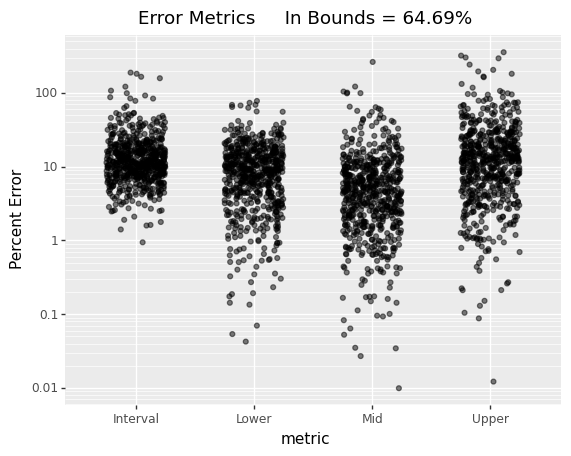

<ggplot: (95011705323)>

In [178]:
percent_in_bounds = metrics['in_bounds'].mean() * 100
metrics_to_plot = predictions[[col for col in predictions if 'percent_error' in col]]

# Rename the columns
metrics_to_plot.columns = [column.split('_')[-1].title() for column in metrics_to_plot]

dat = metrics_to_plot.melt(var_name="metric", value_name='Percent Error')

(ggplot(dat,aes(x="metric",y="Percent Error")) +
  geom_jitter(width = .25,alpha=.5,show_legend=False) +
  scale_y_log10() +
  labs(title=f"Error Metrics     In Bounds = {percent_in_bounds:.2f}%"))

# Non-parametric, KNN

In [179]:
knn = KNeighborsRegressor(n_neighbors=1)
knn.fit(Xtrain, ytrain)


KNeighborsRegressor(n_neighbors=1)

In [118]:
# split the data into a train and validation sets 
#X1, X2, y1, y2 = train_test_split(Xtrain, ytrain, test_size=0.5) 

# base_model can be any regression 
#modelbase_mode.fit(X1, y1) 
base_prediction = knn.predict(X2) 

#compute the RMSE value 
error = mean_squared_error(base_prediction, y2) ** 0.5 

# compute the mean and standard deviation of the distribution 
mean = knn.predict(Xtest) 
st_dev = error

In [126]:
error_model = LinearRegression()

https://medium.com/@qucit/a-simple-technique-to-estimate-prediction-intervals-for-any-regression-model-2dd73f630bcb

In [192]:
# split the data in train a validation set
#X1, X2, y1, y2 = train_test_split(X, y, test_size=0.5)

# base_model can be any regression model 
knn.fit(Xtrain, ytrain) 
base_prediction = knn.predict(Xtest) 

# compute the prediction error vector on the validation set 
validation_error = (base_prediction - ytest) ** 2 
error_model.fit(Xtest, validation_error) 

# compute the mean and standard deviation of the distribution 
mean = knn.predict(Xtest)
error = error_model.predict(Xtest)

In [ ]:
# mean plus or minus (st_dv)*tstat for prediction%
# https://otexts.com/fpp2/prediction-intervals.html

## evaluate error model, find best error model

In [225]:
knnPredictions = pd.DataFrame(ytest)
knnPredictions['std'] = error
knnPredictions['std'] = knnPredictions['std'].abs()**0.5

In [199]:
from scipy.stats import t


## sample size
N = len(knnPredictions)

## degrees of freedom
df = 2*N - 2

t = t.ppf(0.95, df)

In [226]:
knnPredictions['mid'] = knn.predict(Xtest)
knnPredictions['lower'] = knnPredictions['mid'] - (knnPredictions['std']*t)

knnPredictions['upper'] = knnPredictions['mid'] + (knnPredictions['std']*t)

#assert (predictions['upper'] > predictions['lower']).all()

knnPredictions.tail()

,total_votes_2020,std,mid,lower,upper
2569,16819.0,27182.245049,18973.0,-25771.134708,63717.134708
2399,930.0,80831.404737,516.0,-132538.913443,133570.913443
2468,36795.0,113423.997403,38487.0,-148217.910127,225191.910127
1301,17675.0,67335.018835,18292.0,-92546.790097,129130.790097
2911,1165.0,20535.761004,1982.0,-31821.493973,35785.493973


In [227]:
knnPredictions = calculate_error(knnPredictions)

C:\Users\madel\anaconda3\lib\site-packages\plotnine\utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


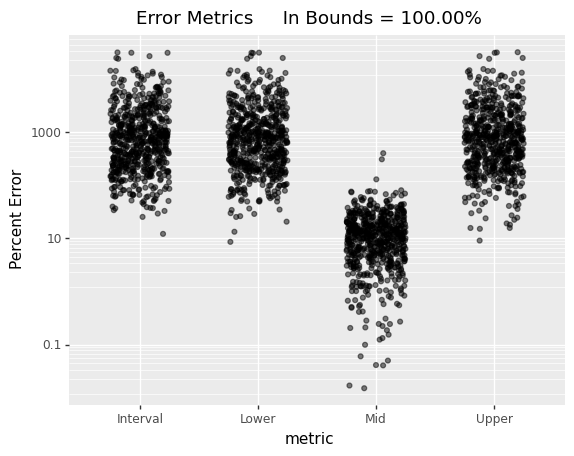

<ggplot: (95010281337)>

In [228]:
percent_in_bounds = knnPredictions['in_bounds'].mean() * 100
metrics_to_plot = knnPredictions[[col for col in knnPredictions if 'percent_error' in col]]

# Rename the columns
metrics_to_plot.columns = [column.split('_')[-1].title() for column in metrics_to_plot]

dat = metrics_to_plot.melt(var_name="metric", value_name='Percent Error')

(ggplot(dat,aes(x="metric",y="Percent Error")) +
  geom_jitter(width = .25,alpha=.5,show_legend=False) +
  scale_y_log10() +
  labs(title=f"Error Metrics     In Bounds = {percent_in_bounds:.2f}%"))

https://github.com/msesia/cqr-comparison

https://github.com/ying531/qtl_reg